# Test of bespoke neural network

Import necessary modules:

In [1]:
from classes.MyModel import MyModel
import torch
import torch.nn as nn
import math as math
from pathlib import Path
from torchviz import make_dot

from modules.helper_functions_tsp import (find_problem_size,
                                          find_distances_array,
                                          cost_fn_fact, 
                                          cost_fn_tensor, 
                                          hot_start, 
                                          hot_start_list_to_string)

from modules.config import GRAPH_DIR
from modules.helper_ML_functions import (find_device, 
                                         get_ready_to_train,
                                         train_model)

from modules.graph_functions import (plot_sine_activation,
                                     plot_model_training)

Set up constants:

In [2]:
LOCATIONS = 8                       #locations in problem
DECODING_FORMULATION = 'original'   #decoding formulation
                                    #options: 'original', 'new'
GRAY = False                        #gray code  
STD_DEV = 0.5                       #standard deviation for weight randomization
NUM_EPOCHS = 50                     #number of epochs for training
NUM_LAYERS = 2                      #number of layers in the mode
LR = 0.0001                         #Learning rate
VERBOSE = False                     #controls how much output the model produces
SHOTS = 64                          #size of input tensor.  Reduces randomness
MOMENTUM = 0.000                    #momentum for optimizer
WEIGHT_DECAY = 0.0002               #importance of L2 regularization in optimiser
OPTIMIZER = 'SGD'                   #optimizer to use
                                    #options: 'Adam', 'SGD', 'RMSprop
     

Read in data, report on data read and validate distance array:

In [3]:
distance_array, best_dist = find_distances_array(LOCATIONS, print_comments=True)

Reading distance data
Data will be read from filename networks\sim_dist_8_locs.txt.
It is known that the shortest distance is 277.2


Evaluate cost function and clear cache:

In [4]:
cost_fn = cost_fn_fact(LOCATIONS, distance_array, GRAY, method = DECODING_FORMULATION, verbose=VERBOSE)
cost_fn.clear_cache()

Check if CUDA is available and set the device

In [5]:
device = find_device()
print(f"Using device: {device}")

Using device: cuda


Find problem size:

In [6]:
qubits = find_problem_size(LOCATIONS, DECODING_FORMULATION)
print(f'There are {qubits} qubits needed for {LOCATIONS} locations in the {DECODING_FORMULATION} formulation.')

There are 14 qubits needed for 8 locations in the original formulation.


Find a hot start using a lazy classical algorithm and find the quality of the hot start:

In [7]:
hot_start_list = hot_start(distance_array, LOCATIONS)
print(f'The hot start location list is {hot_start_list}')
bin_hot_start_list =  hot_start_list_to_string(hot_start_list, LOCATIONS, GRAY, DECODING_FORMULATION)
print(f'This is equivalent to a binary list: {bin_hot_start_list}')
bin_hot_start_list_tensor = torch.tensor([bin_hot_start_list])
print(f'bin_hot_start_list_tensor = {bin_hot_start_list_tensor}')
distance_tensor = cost_fn_tensor(bin_hot_start_list_tensor, cost_fn).clone().detach().requires_grad_(True)
print(f'The hot start distance is {float(distance_tensor):.2f}, compared to a best distance of {best_dist:.2f}.')

The hot start location list is [0, 3, 5, 4, 1, 6, 7, 2]
This is equivalent to a binary list: [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1]
bin_hot_start_list_tensor = tensor([[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1]])
The hot start distance is 315.80, compared to a best distance of 277.20.


Set up input as repeated hot start tensor calculated above:

In [8]:
unrepeated_input = bin_hot_start_list_tensor.float().to(device)
my_input = unrepeated_input.repeat(SHOTS, 1).requires_grad_(True)

Set up model with gradient required:

In [9]:

model = MyModel(qubits, NUM_LAYERS, STD_DEV, cost_fn).to(device)
for param in model.parameters():
    param.requires_grad = True

Report on model parameters:

In [10]:
total_params = sum(
	param.numel() for param in model.parameters()
)
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

print(f'There are {total_params} parameters in total, of which {trainable_params} are trainable')

for name, param in model.named_parameters():
    print(f"Parameter {name} requires_grad: {param.requires_grad}")

There are 420 parameters in total, of which 420 are trainable
Parameter fc1.weight requires_grad: True
Parameter fc1.bias requires_grad: True
Parameter fc2.weight requires_grad: True
Parameter fc2.bias requires_grad: True


Test the Sine activation function and print out a graph:

Plot the sine activation function:

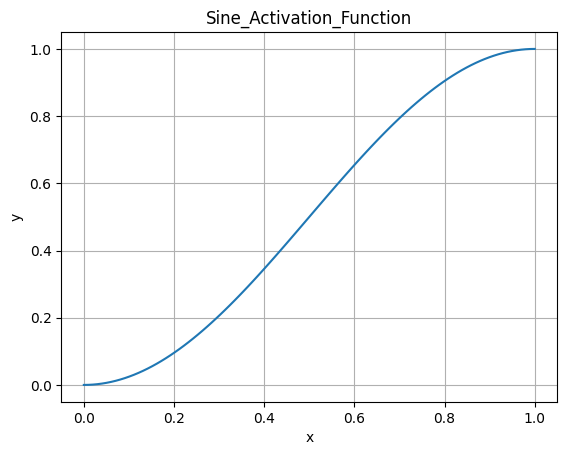

In [11]:
plot_sine_activation()

Print out model details including graph

Output = 487.5406188964844
{'fc1.weight': Parameter containing:
tensor([[ 9.3401e-01, -1.7555e-01,  1.4946e-03, -1.6914e-01,  1.2886e-01,
         -2.2914e-01, -9.9353e-01, -5.1802e-01,  2.9748e-01,  5.4071e-01,
         -7.0152e-01, -3.7004e-01,  5.2785e-01, -7.5210e-02],
        [ 1.8662e-01,  3.4879e-01,  1.6842e-01,  1.6802e-01, -3.1173e-01,
          3.2964e-01,  5.1882e-02, -3.0332e-01, -5.6892e-01,  1.8771e-01,
          4.7398e-01,  1.0891e+00, -2.1474e-01,  5.7553e-01],
        [-1.4976e-01, -5.1597e-02,  1.2567e+00,  1.2982e-01,  1.1444e+00,
          2.0181e-01,  2.1260e-01,  7.3160e-01, -4.0688e-01,  1.0805e+00,
         -7.4396e-02,  5.4964e-01, -3.3726e-01,  2.6977e-01],
        [-7.6879e-01, -6.7028e-01,  4.1977e-02,  1.0346e+00,  2.8515e-01,
          5.6803e-02, -1.1495e+00, -5.3048e-01,  1.2783e+00,  2.4192e-01,
          3.9190e-01, -7.9548e-02, -4.3858e-01,  8.3746e-01],
        [ 3.0761e-01,  2.0108e-01, -2.5324e-01, -2.5597e-01,  2.0031e+00,
          2.4603e-01, 

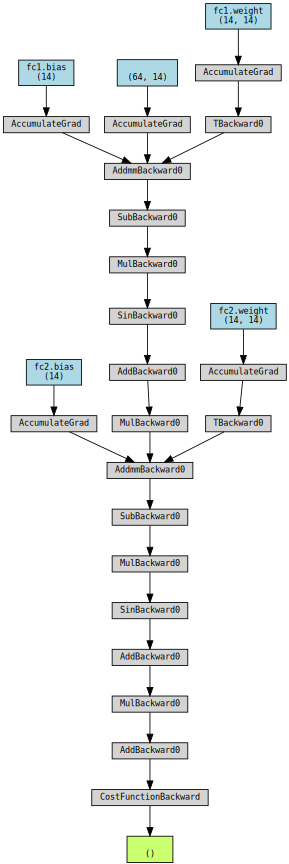

In [12]:
output = model(my_input)
lowest_cost = float(output)
print(f'Output = {output}')
filename = Path(GRAPH_DIR).joinpath('torchviz')

param_dict = dict(model.named_parameters())
print(param_dict)  # Debugging: print the parameters to ensure they seem reasonable
make_dot(output, params=param_dict).render(filename, format="png")
make_dot(output, params=param_dict)

Set up criterion, optimizer and target ready to train model.

In [13]:
target, criterion, optimizer = get_ready_to_train(model, OPTIMIZER, LR, WEIGHT_DECAY, momentum = MOMENTUM)

Train model and print out results:

In [14]:
lowest_cost, epoch_lowest_cost, epoch_hist, loss_hist, lowest_history = \
    train_model(NUM_EPOCHS,
                model, 
                my_input, 
                target, 
                criterion,
                optimizer,
                print_results=True)

Epoch 0, Cost: 494.825, Lowest Cost to date =  490.217
Epoch 0, fc1.weight grad: 25900.20
Epoch 0, fc1.bias grad: 10573.71
Epoch 0, fc2.weight grad: 8476.18
Epoch 0, fc2.bias grad: 3979.61


In [15]:
print(f'The lowest cost found was {lowest_cost:.3f} at epoch {epoch_lowest_cost}.')
print(f'The best known cost is {best_dist:.3f} and the hot start cost was {float(distance_tensor):.3f}.')

The lowest cost found was 433.638 at epoch 37.
The best known cost is 277.200 and the hot start cost was 315.800.


Plot loss ratio by epoch:

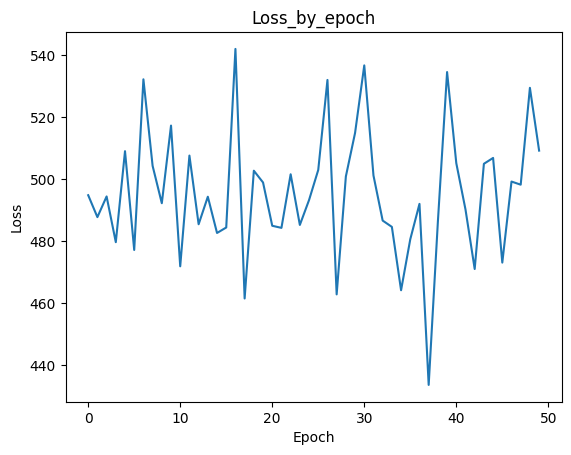

In [16]:
plot_model_training(epoch_hist, loss_hist)

Print out parameters:

In [17]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print('weight:', layer.weight)
        print('bias:', layer.bias)

weight: Parameter containing:
tensor([[ 9.3401e-01,  8.4329e-02,  1.4946e-03, -1.6914e-01,  3.8874e-01,
          3.0732e-02, -9.9353e-01, -2.5814e-01,  2.9748e-01,  5.4071e-01,
         -7.0152e-01, -3.7004e-01,  7.8773e-01,  1.8467e-01],
        [ 1.8662e-01,  7.8316e-01,  1.6842e-01,  1.6802e-01,  1.2265e-01,
          7.6401e-01,  5.1882e-02,  1.3105e-01, -5.6892e-01,  1.8771e-01,
          4.7398e-01,  1.0891e+00,  2.1963e-01,  1.0099e+00],
        [-1.4976e-01,  3.5206e+00,  1.2567e+00,  1.2982e-01,  4.7166e+00,
          3.7740e+00,  2.1260e-01,  4.3038e+00, -4.0688e-01,  1.0805e+00,
         -7.4396e-02,  5.4964e-01,  3.2350e+00,  3.8420e+00],
        [-7.6879e-01,  3.2252e+00,  4.1977e-02,  1.0346e+00,  4.1806e+00,
          3.9523e+00, -1.1495e+00,  3.3650e+00,  1.2783e+00,  2.4192e-01,
          3.9190e-01, -7.9548e-02,  3.4569e+00,  4.7329e+00],
        [ 3.0761e-01,  2.7120e+00, -2.5324e-01, -2.5597e-01,  4.5140e+00,
          2.7569e+00, -2.3263e-01,  2.2521e+00, -2.9958e